In [16]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt
import multiprocessing as mp
import time
import warnings
warnings.filterwarnings('ignore')

In [17]:
nqubits = 4         # Num qubits, min 4, always 2**num_layers qubits
num_iters = 150      # Number of training iterations
optimizer = "Adam"  # "Adam", "Nesterov"
loss_type = "cross-entropy" # "projectors", "cross-entropy"
with_bias = False    # Add a bias to the output of the quantum circuit
balanced_classes = False     # True: Same number of datapoints for each class. False: We cover homologously the j1,j2 space 
random = True

num_cpus_batch = 0
num_cpus_train = 0

# Data hyper-parameters
num_data = 100      # How many ground states do we want?
num_train = 75      # Ground states that will be used for training
batch_size = 20     # batch training size

# Tweak hyper-parameters
max_weight_init = 0.01  # weight_init goes from 0 to this number. Max = 2*np.pi. Other options = 0.01
stepsize = 0.02         # stepsize of the gradient descent.

# Constant definitions
layers = int(np.log2(nqubits))
nweights = 30*(layers-1) + 15
rng = np.random

In [18]:
def X(i):
    return qml.PauliX(i)

def Z(i):
    return qml.PauliZ(i)

# Gound states

In [19]:
def ground_state(j1, j2):
    
    hamiltonian = 0
    for i in range(nqubits):
        hamiltonian += Z(i)
        hamiltonian -= j1 * X(i) @ X((i+1)%nqubits)
        hamiltonian -= j2 * X((i-1)%nqubits) @ Z(i) @ X((i+1)%nqubits)
    
    _, eigvecs = np.linalg.eigh(qml.matrix(hamiltonian))
    
    return eigvecs[:,0]

In [20]:
# Definir las coordenadas de los puntos de cada región
region01_coords = np.array([(-2, 1), (2, 1), (4, 3), (4, 4), (-4, 4), (-4, 3)])    # Class 0
region02_coords = np.array([(-3, -4), (0, -1), (3, -4)])                           # Class 0
region1_coords = np.array([(0, -1), (3, -4), (4, -4), (4, 3)])                     # Class 1
region2_coords = np.array([(0, -1), (-3, -4), (-4, -4), (-4, 3)])                  # Class 2
region3_coords = np.array([(-2, 1), (2, 1), (0, -1)])                              # Class 3

def labeling(x, y):

    # Crear objetos Polygon para cada región
    region01_poly = Polygon(region01_coords)
    region02_poly = Polygon(region02_coords)
    region1_poly = Polygon(region1_coords)
    region2_poly = Polygon(region2_coords)
    region3_poly = Polygon(region3_coords)
    
    
    punto = Point(x, y)
    if region01_poly.contains(punto):
        return 0
    elif region02_poly.contains(punto):
        return 0
    elif region1_poly.contains(punto):
        return 1
    elif region2_poly.contains(punto):
        return 2
    elif region3_poly.contains(punto):
        return 3
    else:
        return None # Si el punto no está en ninguna región

In [21]:
if not random:
    rng = np.random.RandomState(0)

if balanced_classes:
    
    npoints_class = num_data//4
    num_data = 4*npoints_class
    j_list = []
    num_0, num_1, num_2, num_3 = 0, 0, 0, 0

    while num_0 != npoints_class or num_1 != npoints_class or num_2 != npoints_class or num_3 != npoints_class:
        j = rng.uniform(-4, 4, 2)
        l = labeling(j[0], j[1])

        if l==0 and num_0 < npoints_class:
            num_0 += 1
            j_list.append(j)
        elif l==1 and num_1 < npoints_class:
            num_1 += 1
            j_list.append(j)
        elif l==2 and num_2 < npoints_class:
            num_2 += 1
            j_list.append(j)
        elif l==3 and num_3 < npoints_class:
            num_3 += 1
            j_list.append(j)

    j_list = np.array(j_list)
    
else:
    j_list = rng.uniform(-4, 4, (num_data,2))


gs_list = []
labels_list = []
for i in range(num_data):
    gs_list.append(ground_state(j_list[i,0], j_list[i,1]))
    labels_list.append(labeling(j_list[i,0], j_list[i,1]))

gs_list = np.array(gs_list)
labels_list = np.array(labels_list)

In [22]:
print(gs_list.shape)

(100, 16)


# CNN

In [23]:
def convolutional_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

def pooling_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

In [24]:
def cnn_circuit(weights, state_ini):
    
    qubits = list(range(nqubits))
    
    qml.QubitStateVector(state_ini, wires=qubits)

    for j in range(layers-1):
        
        len_qubits = len(qubits)
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*2*j:15*(2*j+1)])
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i+1], qubits[(2*i+2)%len_qubits], weights[15*2*j:15*(2*j+1)])
            
        for i in range(len_qubits//2):
            pooling_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*(2*j+1):15*(2*j+2)])

        qub = []
        for i in range(len_qubits):
            if i%2 == 1:
                qub.append(qubits[i])
                
        qubits = qub
    
    convolutional_layer(qubits[0], qubits[1], weights[15*(2*layers-2):15*(2*layers-1)])
    
    return qml.expval(Z(qubits[0])), qml.expval(Z(qubits[1])), qml.expval(Z(qubits[0]) @ Z(qubits[1]))

# dev_draw = qml.device("qiskit.aer", wires=nqubits)
dev = qml.device("default.qubit", wires=nqubits)

# cnn_draw = qml.QNode(cnn_circuit, dev_draw)
cnn_circuit = qml.QNode(cnn_circuit, dev, interface="auto", diff_method="best")


def cnn(weights, state_ini):
    z0, z1, zz01 = cnn_circuit(weights, state_ini)

    proj_00 = (1+zz01+z0+z1)/4
    proj_01 = (1-zz01-z0+z1)/4
    proj_10 = (1-zz01+z0-z1)/4
    proj_11 = (1+zz01-z0-z1)/4

    return pnp.array([proj_00, proj_01, proj_10, proj_11])

In [25]:
def variational_classifier(weights, bias, state_ini):
    return cnn(weights, state_ini) + bias

In [26]:
weights = np.random.uniform(0, 2*np.pi, nweights)
drawer = qml.draw(cnn_circuit)
print(drawer(weights, gs_list[0]))

# z0, z1, zz01 = cnn_draw(gs_list[0], weights)
# print(z0, z1, zz01)
# dev_draw._circuit.draw(output="mpl")

0: ─╭|Ψ⟩──U3(0.61,2.69,4.80)──U3(4.80,4.01,0.38)─╭X──RZ(2.25)─╭●───────────╭X──U3(3.20,3.98,5.86)
1: ─├|Ψ⟩─────────────────────────────────────────╰●──RY(6.09)─╰X──RY(5.69)─╰●──U3(0.61,2.69,4.80)
2: ─├|Ψ⟩──U3(0.61,2.69,4.80)──U3(4.80,4.01,0.38)─╭X──RZ(2.25)─╭●───────────╭X──U3(3.20,3.98,5.86)
3: ─╰|Ψ⟩─────────────────────────────────────────╰●──RY(6.09)─╰X──RY(5.69)─╰●──U3(0.61,2.69,4.80)

───U3(0.05,4.97,3.40)──────────────────────────────────────────────────────────────────────╭●
───U3(4.80,4.01,0.38)─╭X──RZ(2.25)─╭●───────────╭X──U3(3.20,3.98,5.86)──U3(0.05,4.97,3.40)─│─
───U3(0.05,4.97,3.40)─╰●──RY(6.09)─╰X──RY(5.69)─╰●─────────────────────────────────────────│─
───U3(4.80,4.01,0.38)──────────────────────────────────────────────────────────────────────╰X

───RY(6.09)─╭X──RY(5.69)─╭●──U3(4.09,5.74,3.92)──U3(2.07,1.15,4.64)─╭X──RZ(0.17)─╭●───────────╭X
────────────│────────────│──────────────────────────────────────────╰●──RY(5.15)─╰X──RY(0.11)─╰●
────────────│────────────│───U3(4.09

# Loss and accuracy

In [27]:
def log2_arraybox(abox):
    return pnp._np.numpy_boxes.ArrayBox(value = np.log2(abox._value), trace = abox._trace, node = abox._node)


def exp_arraybox(abox):
    return pnp._np.numpy_boxes.ArrayBox(value = np.exp(abox._value), trace = abox._trace, node = abox._node)


def single_loss(weights, bias, ground_state, label):
    
    proj = variational_classifier(weights, bias, ground_state)

    if loss_type == "projectors":
            cost = proj[label]

    elif loss_type == "cross-entropy":
        
            if isinstance(proj[label], pnp._np.numpy_boxes.ArrayBox):
                cost = -log2_arraybox(proj[label])
            else:
                cost = -np.log2(proj[label])
    
    return cost


def loss(weights, bias, ground_states, labels):
    
    if num_cpus_train == 0:
        cost = 0

        for j in range(len(labels)):
            cost += single_loss(weights, bias, ground_states[j], labels[j])
    
    else:
        args = [[weights, bias, ground_states[j], labels[j]] for j in range(len(labels))]

        with mp.Pool(num_cpus_train) as pool:
            cost_arr = pool.starmap(single_loss, args)

        cost = sum(cost_arr)
    
    return cost/len(labels)

In [28]:
weights_init = pnp.random.uniform(0, max_weight_init, nweights, requires_grad=True)
bias_init = pnp.array([0.0]*4, requires_grad=True)

print(loss(weights_init, bias_init, gs_list, labels_list))

2.122393661989401


In [29]:
def pred_acc(weights, bias, ground_states, labels):
    accuracy_data = 0
    predictions = []

    for j in range(len(labels)):
        projectors = variational_classifier(weights, bias, ground_states[j])
        
        if loss_type == "projectors":
            pred = np.argmin(projectors)
        elif loss_type == "cross-entropy":
            pred = np.argmax(projectors)

        accuracy_data += 1 if pred == labels[j] else 0
        predictions.append(pred)
            
    return predictions, accuracy_data*100/len(labels)

# Training

In [30]:
if not random:
    rng = np.random.RandomState(0)

# Splitting the data into training and validation
index = rng.permutation(range(num_data))

gs_train = gs_list[index[:num_train]]
labels_train = labels_list[index[:num_train]]
gs_val = gs_list[index[num_train:]]
labels_val = labels_list[index[num_train:]]

# We need these later for plotting
j_train = j_list[index[:num_train]]
j_val = j_list[index[num_train:]]

# weights and bias initialization
weights_init = pnp.random.uniform(0, max_weight_init, nweights, requires_grad=True)

if with_bias:
    bias_init = pnp.array([0.0]*4, requires_grad=True)
else:
    bias_init = np.array([0.0]*4)

# train the variational classifier
if optimizer == "Nesterov":
    opt = NesterovMomentumOptimizer(stepsize)
elif optimizer == "Adam":
    opt = qml.AdamOptimizer(stepsize)
    
    
weights = []
bias = []
losses = []
pred_train_arr = []
pred_val_arr = []
acc_train_arr = []
acc_val_arr = []

w = weights_init
b = bias_init

start_time = time.time()

for it in range(num_iters):

    batch_index = np.random.randint(0, num_train, (batch_size,))
    gs_train_batch = gs_train[batch_index]
    labels_train_batch = labels_train[batch_index]
    
    # Update the weights by one optimizer step
    if num_cpus_batch == 0:
        w, b, _, _ = opt.step(loss, w, b, gs_train_batch, labels_train_batch)
        
    else:
        args = [[single_loss, w, b, gs_train_batch[j], labels_train_batch[j]] for j in range(len(labels_train_batch))]

        with mp.Pool(num_cpus_batch) as pool:
            w, b, _, _ = zip(*pool.starmap(opt.step, args))

        w = sum(w)/len(w)
        b = sum(b)/len(b)
    
    weights.append(w)
    bias.append(b)
    
    # Compute predictions and accuracy on train and validation set
    pred_train, acc_train = pred_acc(w, b, gs_train, labels_train)
    pred_val, acc_val = pred_acc(w, b, gs_val, labels_val) if len(labels_val)>0 else [0, 0]

    # Save prediction for later plotting
    pred_train_arr.append(pred_train)
    pred_val_arr.append(pred_val)
    acc_train_arr.append(acc_train)
    acc_val_arr.append(acc_val)

    l = loss(w, b, gs_train, labels_train)
    losses.append(l)

    print(
        "Iter: {:5d} | Loss: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f}"
        "".format(it+1, l, acc_train, acc_val)
    )

print(f"--- {time.time() - start_time} seconds ---")

Iter:     1 | Loss: 2.0810409 | Acc train: 14.6666667 | Acc validation: 4.0000000
Iter:     2 | Loss: 2.0821175 | Acc train: 14.6666667 | Acc validation: 4.0000000
Iter:     3 | Loss: 2.0786950 | Acc train: 14.6666667 | Acc validation: 4.0000000
Iter:     4 | Loss: 2.0796262 | Acc train: 14.6666667 | Acc validation: 4.0000000
Iter:     5 | Loss: 2.0763551 | Acc train: 14.6666667 | Acc validation: 4.0000000
Iter:     6 | Loss: 2.0636054 | Acc train: 14.6666667 | Acc validation: 4.0000000
Iter:     7 | Loss: 2.0493451 | Acc train: 14.6666667 | Acc validation: 4.0000000
Iter:     8 | Loss: 2.0408360 | Acc train: 14.6666667 | Acc validation: 8.0000000
Iter:     9 | Loss: 2.0354897 | Acc train: 14.6666667 | Acc validation: 8.0000000
Iter:    10 | Loss: 2.0349087 | Acc train: 14.6666667 | Acc validation: 8.0000000
Iter:    11 | Loss: 2.0390476 | Acc train: 14.6666667 | Acc validation: 8.0000000
Iter:    12 | Loss: 2.0474545 | Acc train: 17.3333333 | Acc validation: 8.0000000
Iter:    13 | Lo

# Plotting

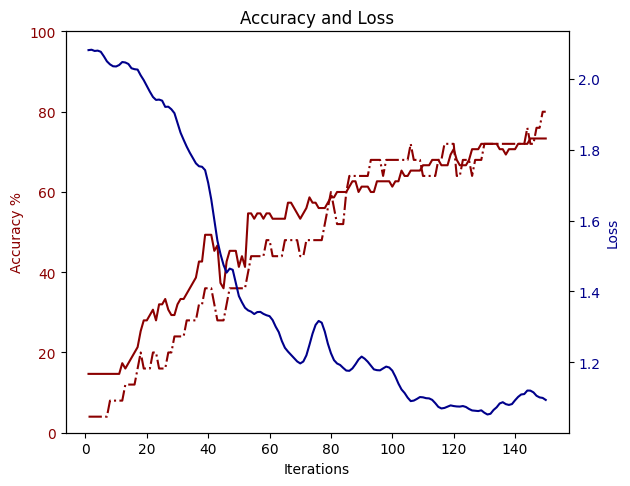

In [31]:
iterations = range(1, len(acc_train_arr)+1)

fig, ax1 = plt.subplots()

color1 = 'darkred'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy %', color=color1)
ax1.plot(iterations, acc_train_arr, label="Training", color=color1)
ax1.plot(iterations, acc_val_arr, '-.', label="Validation", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0,100)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'darkblue'
ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with ax1
ax2.plot(iterations, losses, label="Loss", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
# ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.title("Accuracy and Loss")
plt.show()

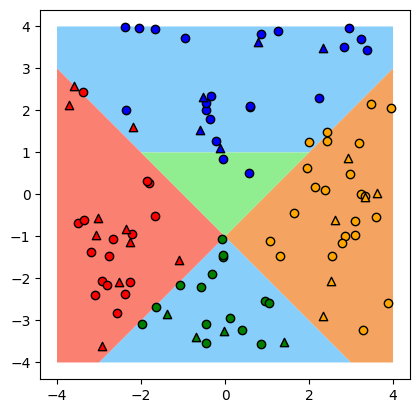

In [32]:
plot_iter = it+1 #it+1

# define regions coordinates
x01, y01 = region01_coords[:,0], region01_coords[:,1]
x02, y02 = region02_coords[:,0], region02_coords[:,1]
x1, y1 = region1_coords[:,0], region1_coords[:,1]
x2, y2 = region2_coords[:,0], region2_coords[:,1]
x3, y3 = region3_coords[:,0], region3_coords[:,1]

# plt.figure(figsize=(8, 8))

# put the regions into the plot
plt.fill(x01, y01, facecolor='lightskyblue')    # class 0
plt.fill(x02, y02, facecolor='lightskyblue')    # class 0
plt.fill(x1, y1, facecolor='sandybrown')        # class 1
plt.fill(x2, y2, facecolor='salmon')            # class 2
plt.fill(x3, y3, facecolor='lightgreen')        # class 3

pred_train_plot = np.array(pred_train_arr[plot_iter-1])
pred_val_plot = np.array(pred_val_arr[plot_iter-1])

colors = ["b", "orange", "r", "g"]

# plot datapoints
for i in range(4):
    plt.scatter(
        j_train[:, 0][pred_train_plot==i],
        j_train[:, 1][pred_train_plot==i],
        c=colors[i],
        marker="o",
        edgecolors="k",
        label=f"class {i+1} train",
    )
    plt.scatter(
        j_val[:, 0][pred_val_plot==i],
        j_val[:, 1][pred_val_plot==i],
        c=colors[i],
        marker="^",
        edgecolors="k",
        label=f"class {i+1} validation",
    )


# plt.legend()
plt.axis('square')
plt.show()


In [33]:
print(mp.cpu_count())

for i in range(10, 20, 1):
    num_cpus = i
    start_time = time.time()
    loss(w, b, gs_train, labels_train)
    print(f"{i} --- {time.time() - start_time} seconds ---")

8
10 --- 1.9211015701293945 seconds ---
11 --- 1.9262948036193848 seconds ---
12 --- 1.9227664470672607 seconds ---
13 --- 1.9113264083862305 seconds ---
14 --- 1.9134016036987305 seconds ---
15 --- 1.9384329319000244 seconds ---
16 --- 2.104572296142578 seconds ---
17 --- 1.9292986392974854 seconds ---
18 --- 1.9134390354156494 seconds ---
19 --- 1.9169166088104248 seconds ---
